# Car accident prediction

## Data Import

In [1]:
import os
import pandas as pd

In [2]:
###access google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dachcam_dataset.zip -u -q

In [4]:
train_dir = "/content/videos/training"
test_dir = "/content/videos/testing"

## Data analysis

In [5]:
train_positive_data = "/content/videos/training/positive"
train_negative_data = "/content/videos/training/negative"

test_positive_data = "/content/videos/testing/positive"
test_positive_data = "/content/videos/testing/negative"

### How much data do we have ?

In [6]:
print(f"Total number of Positive training data: {len(os.listdir(train_positive_data))}")
print(f"Total number of Negative training data: {len(os.listdir(train_negative_data))}")
print(f"Total number of Positve testing data: {len(os.listdir(test_positive_data))}")
print(f"Total number of Negative testing data: {len(os.listdir(test_positive_data))}")

Total number of Positive training data: 455
Total number of Negative training data: 829
Total number of Positve testing data: 301
Total number of Negative testing data: 301


What are the properties of the videos ?

In [7]:
import cv2
def get_video_properties(video_path):
	video = cv2.VideoCapture(video_path)
	length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
	width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
	height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
	fps    = video.get(cv2.CAP_PROP_FPS)
	return length, width, height, fps

In [8]:
seq_len, vid_width, vid_height, fps = get_video_properties("/content/videos/training/positive/000010.mp4")

In [9]:
print(f"Sequence length of videos: {seq_len}")
print(f"Video height: {vid_height}")
print(f"Video width: {vid_width}")
print(f"FPS of video:  {fps}")

Sequence length of videos: 100
Video height: 720
Video width: 1280
FPS of video:  25.0


## Data preparation
Each video contains 100 frames at 25fps and accidents only occur in the last 50 frames(approximately around the 75th frame). So we'll pass the model the first 50 frames as input and it's goal will be to use that to predict whether or not they'll be a car accident in the remaining 50 frames.  

In [10]:
import numpy as np
import concurrent.futures

In [11]:
def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
    while count <= seq_len:   
        success, image = vidObj.read() 
        if success:
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (vid_height, vid_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
    #return only the first 50 frames, so model makes predict for the next 50 frames
    return frames_list

In [12]:
def create_data(input_dir, seq_len, classes):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
          frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
          if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [13]:
vid_height , vid_width = 30, 30
seq_len = 50
classes = ["negative", "positive"]

#Need to thread this or use multiprocessing to make this faster
import time
start = time.perf_counter()
X_train, y_train = create_data(train_dir, seq_len, classes) 
X_test, y_test =  create_data(test_dir, seq_len, classes)
finish = time.perf_counter()
print(f"Finished in {round(finish-start,2)} seconds.")

positive
negative
positive
negative
Finished in 537.11 seconds.


In [38]:
print(X_train.shape, y_train.shape)

(1284, 50, 30, 30) (1284, 2)


## Build model

In [14]:
import keras
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, MaxPool2D, GlobalMaxPool2D

In [15]:
def build_convnet(shape=(vid_height, vid_width, 1)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(32, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    model.add(MaxPool2D())

    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    model.add(MaxPool2D())
     
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(seq_len, vid_height, vid_width, 3), nbout=classes):
    # Create our convnet with (vid_height, vid_width, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (seq_len, 224, 224, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

SIZE = (vid_height,vid_width,)
CHANNELS = 1
INSHAPE=(seq_len,) + SIZE + (CHANNELS,) # (50, 224, 224, 1)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)

model.summary()

model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 50, 32)           46944     
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

## Train model

In [16]:
# ##Early stop to avoid over-fitting 
# earlystop = EarlyStopping(patience=7)
# callbacks = [earlystop]

In [22]:
import time 
#####start the training 

start = time.perf_counter()
history = model.fit(
      x = X_train, 
      y = y_train, 
      epochs=100,
      steps_per_epoch = 100 ,
      batch_size = 8, 
      shuffle=True, 
      validation_split=0.1)
finish = time.perf_counter()
print(f"Finished in {round(finish-start,2)} seconds.")

Epoch 1/100
100/100 [==============================] - 2s 24ms/step - loss: 0.6673 - acc: 0.6125 - val_loss: 0.5107 - val_acc: 1.0000
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.6771 - acc: 0.5975 - val_loss: 0.5474 - val_acc: 1.0000
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - loss: 0.6713 - acc: 0.6113 - val_loss: 0.5174 - val_acc: 1.0000
Epoch 4/100
100/100 [==============================] - 3s 25ms/step - loss: 0.6785 - acc: 0.5888 - val_loss: 0.5328 - val_acc: 1.0000
Epoch 5/100
100/100 [==============================] - 2s 23ms/step - loss: 0.6628 - acc: 0.6138 - val_loss: 0.4410 - val_acc: 1.0000
Epoch 6/100
100/100 [==============================] - 2s 23ms/step - loss: 0.6751 - acc: 0.5962 - val_loss: 0.5256 - val_acc: 1.0000
Epoch 7/100
100/100 [==============================] - 2s 24ms/step - loss: 0.6699 - acc: 0.6037 - val_loss: 0.5005 - val_acc: 1.0000
Epoch 8/100
100/100 [==============================] - 2s 24ms

## Test model

In [18]:
from sklearn.metrics import classification_report

In [39]:
y_test.shape

(466, 2)

In [40]:
y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
#print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 17ms/step
(466, 2)


In [49]:
y_test2 = np.argmax(y_test, axis=1)
y_pred2 = np.argmax(y_pred, axis=1)

In [ ]:
y_test2.shape

In [ ]:
y_pred2.shape

In [54]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       301
           1       0.37      0.47      0.42       165

    accuracy                           0.53       466
   macro avg       0.52      0.52      0.51       466
weighted avg       0.56      0.53      0.54       466



Text(0.5, 1.0, 'Training and validation loss')

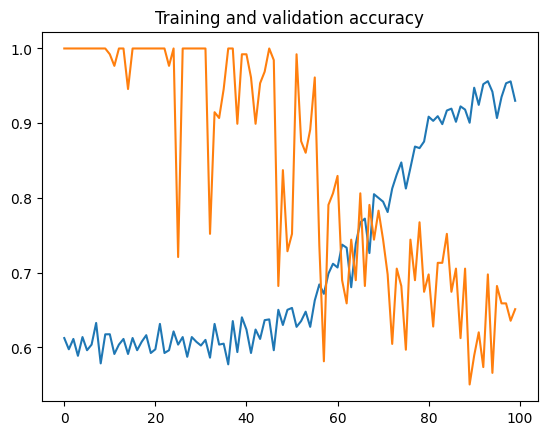

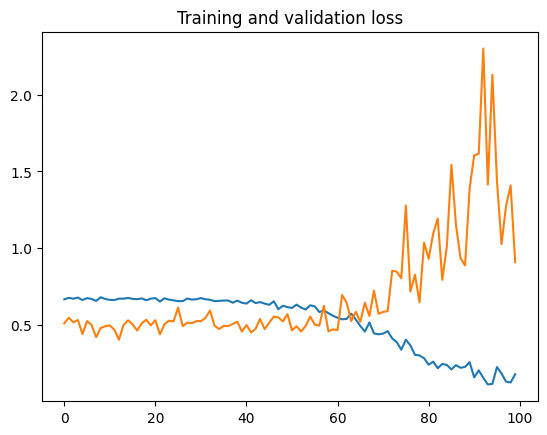

In [55]:
from matplotlib import pyplot as plt
###Evaluate accuracy and loss of model 
###Sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

###Get number of epochs
epochs = range(len(acc))

###Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

###Plot training and Validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Save model

In [56]:
####save model

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("my_h5_model.h5")